In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_distances
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from wordcloud import WordCloud

In [440]:
#colors = ['olive','#0d42ba','coral','#0d98ba','#a95292','maroon','#279989','hotpink','#1a405a','#f25e60',,'#0dba86',,'#95b211','#071d49','#ffbfb7','#244c96']
colors = ['#581845','#eac05f','maroon','#DAF7A6','#fe8402','#C70039']


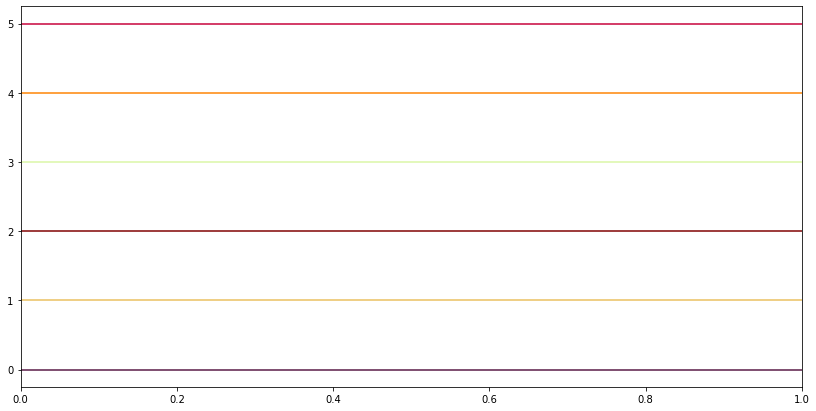

In [441]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
for idx, color in enumerate(colors):
    ax.axhline(idx,color=color)
plt.show()

In [2]:
raw_data = '../data/winemag-data-190314.csv'

In [3]:
df = pd.read_csv(raw_data)

In [4]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)

In [5]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141617 entries, 0 to 141616
Data columns (total 14 columns):
country                  141556 non-null object
description              141617 non-null object
designation              101435 non-null object
points                   141617 non-null int64
price                    131959 non-null float64
province                 141556 non-null object
region_1                 118731 non-null object
region_2                 54785 non-null object
taster_name              116700 non-null object
taster_twitter_handle    110968 non-null object
title                    141617 non-null object
variety                  141616 non-null object
winery                   141617 non-null object
vintage                  136383 non-null float64
dtypes: float64(2), int64(1), object(11)
memory usage: 15.1+ MB


In [8]:
df.describe()

,points,price,vintage
count,141617.000000,131959.000000,136383.000000
mean,88.565561,36.247221,2011.264366
std,3.079296,45.981721,4.007991
min,80.000000,4.000000,1904.000000
25%,86.000000,17.000000,2009.000000
50%,88.000000,26.000000,2012.000000
75%,91.000000,44.000000,2014.000000
max,100.000000,5000.000000,2018.000000


## Country

In [9]:
country = df.groupby('country').count()['description']
country.reset_index
country.sort_values(ascending=False)

country
US                        58821
France                    25169
Italy                     21200
Spain                      7185
Portugal                   6160
Chile                      4683
Argentina                  3997
Austria                    3604
Australia                  2579
Germany                    2468
New Zealand                1556
South Africa               1489
Israel                      577
Greece                      470
Canada                      262
Bulgaria                    157
Hungary                     148
Uruguay                     112
Romania                     105
Turkey                       90
Moldova                      86
England                      85
Georgia                      84
Croatia                      83
Slovenia                     81
Mexico                       70
Brazil                       50
Lebanon                      32
Morocco                      24
Switzerland                  17
Peru                         16


In [88]:
points = df.groupby('points').count()['description']
#points.sort_values(ascending=False)

In [89]:
points

points
80       411
81       735
82      1936
83      3206
84      6697
85     10092
86     13190
87     17829
88     18408
89     13572
90     16885
91     12662
92     10787
93      7555
94      4441
95      1964
96       732
97       318
98       119
99        44
100       34
Name: description, dtype: int64

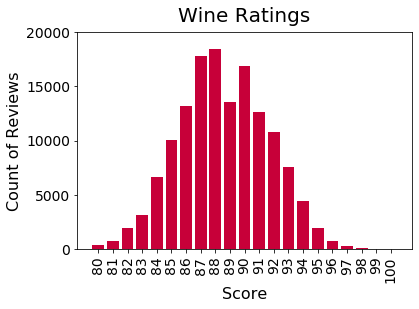

In [449]:
fig, ax = plt.subplots()
xvals = list(points.index)
yvals = points.values
plt.xticks(rotation='vertical',fontsize=14)
ax.bar(xvals,yvals,color=colors[5])
ax.tick_params(axis="y", labelsize=14)
ax.set_xticks(xvals)
y_ticks = np.linspace(0,20000,5)
ax.set_yticks(y_ticks)
ax.set_xlabel("Score",fontsize=16)
ax.set_ylabel("Count of Reviews",fontsize=16)
ax.set_title("Wine Ratings",fontsize=20,pad=10);

## Variety

In [9]:
variety = df.groupby('variety').count()['description']
variety = variety.sort_values(ascending=False)

In [10]:
variety

variety
Pinot Noir                    14695
Chardonnay                    12546
Cabernet Sauvignon            10107
Red Blend                      9635
Bordeaux-style Red Blend       7878
Riesling                       5588
Sauvignon Blanc                5407
Syrah                          4357
Rosé                           4061
Nebbiolo                       3277
Merlot                         3230
Sangiovese                     2957
Zinfandel                      2907
Malbec                         2863
Portuguese Red                 2671
White Blend                    2541
Sparkling Blend                2519
Tempranillo                    2021
Rhône-style Red Blend          1742
Champagne Blend                1575
Pinot Gris                     1570
Cabernet Franc                 1463
Grüner Veltliner               1429
Portuguese White               1260
Bordeaux-style White Blend     1201
Gamay                          1190
Pinot Grigio                   1109
Gewürztraminer      

In [13]:
variety_list = list(variety.index)

In [14]:
len(variety_list)

758

In [18]:
variety_df = pd.DataFrame(variety_list)

In [20]:
# export variety to map category (red, white, rose)
variety_df.to_csv('varietylist')

In [105]:
top_15_variety = variety[:15]
top_15_variety

variety
Pinot Noir                  14695
Chardonnay                  12546
Cabernet Sauvignon          10107
Red Blend                    9635
Bordeaux-style Red Blend     7878
Riesling                     5588
Sauvignon Blanc              5407
Syrah                        4357
Rosé                         4061
Nebbiolo                     3277
Merlot                       3230
Sangiovese                   2957
Zinfandel                    2907
Malbec                       2863
Portuguese Red               2671
Name: description, dtype: int64

In [21]:
df[df['variety']=='Sauvignon'][:5]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
175,Italy,Crisp and fresh with enduring aromas of tomato...,De Silva,88,25.0,Northeastern Italy,Alto Adige,NaN,NaN,NaN,Tenuta Peter Sölva & Söhne 2007 De Silva Sauvi...,Sauvignon,Tenuta Peter Sölva & Söhne,2007.0
279,Italy,"This oak-fermented Sauvignon (in an artsy, scr...",NaN,89,52.0,Northeastern Italy,Alto Adige,NaN,NaN,NaN,Franz Haas 2009 Sauvignon (Alto Adige),Sauvignon,Franz Haas,2009.0
489,Italy,"This bright white is redolent of tomato leaf, ...",NaN,87,13.0,Northeastern Italy,Friuli Grave,NaN,NaN,NaN,Vigneti Le Monde 2010 Sauvignon (Friuli Grave),Sauvignon,Vigneti Le Monde,2010.0
650,Italy,"You'll find aromas of tomato leaf, passion fru...",NaN,92,24.0,Northeastern Italy,Collio,NaN,Kerin O’Keefe,@kerinokeefe,Sturm 2014 Sauvignon (Collio),Sauvignon,Sturm,2014.0
1292,Italy,This vibrant wine opens with varietal aromas o...,NaN,89,13.0,Northeastern Italy,Trentino,NaN,Kerin O’Keefe,@kerinokeefe,Cembra 2013 Sauvignon (Trentino),Sauvignon,Cembra,2013.0


In [68]:
variety_map = pd.read_csv('../data/varietylist.csv')

In [69]:
variety_map.head()

,Unnamed: 0,0
0,Pinot Noir,red
1,Chardonnay,white
2,Cabernet Sauvignon,red
3,Red Blend,red
4,Bordeaux-style Red Blend,red


In [70]:
variety_map['0'].value_counts()

red          393
white        349
rose          11
sparkling      4
other          1
Name: 0, dtype: int64

In [71]:
test_df = df.merge(variety_map,how='left',left_on='variety',right_on='Unnamed: 0')

In [72]:
test_df.drop('Unnamed: 0',axis=1,inplace=True)

In [73]:
test_df.rename(columns = {'0':'category'},inplace=True)

In [74]:
test_df.to_csv('winemag_data_inclcategory.csv')

In [51]:
full_df = pd.read_csv('winemag_data_inclcategory.csv',index_col=0)

## testing scaling price and making category dummies

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [55]:
price = full_df['price']

In [59]:
price.dropna(inplace=True)

In [63]:
full_df['price'] = scaler.fit_transform(full_df[['price']])

In [65]:
full_df['price'] = full_df['price']*3

In [67]:
pd.get_dummies(full_df, prefix=['category'], columns=['category'])

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,category_other,category_red,category_rose,category_sparkling,category_white
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0,0,0,0,0,1
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,0.006605,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0,0,1,0,0,0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,0.006005,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0,0,0,0,0,1
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,0.005404,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0,0,0,0,0,1
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,0.036629,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0,0,1,0,0,0
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,0.006605,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011.0,0,1,0,0,0
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,0.007206,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013.0,0,1,0,0,0
7,France,This dry and restrained wine offers spice in p...,NaN,87,0.012010,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,2012.0,0,0,0,0,1
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,0.004804,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,2013.0,0,0,0,0,1
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,0.013811,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012.0,0,0,0,0,1


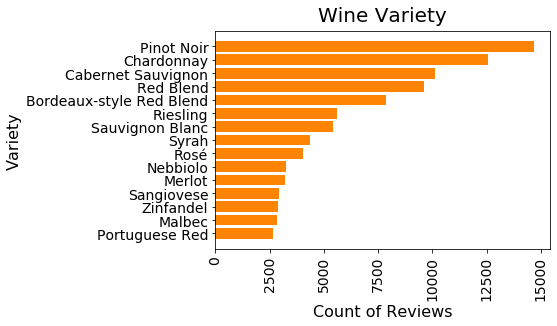

In [453]:
fig, ax = plt.subplots()
yvals = list(top_15_variety.index)
xvals = top_15_variety.values
plt.xticks(rotation='vertical',fontsize=14)
ax.barh(yvals,xvals,color=colors[4])
ax.tick_params(axis="y", labelsize=14)
ax.set_yticks(yvals)
x_ticks = np.linspace(0,15000,7)
ax.set_xticks(x_ticks)
ax.set_ylabel("Variety",fontsize=16)
ax.set_xlabel("Count of Reviews",fontsize=16)
ax.set_title("Wine Variety",fontsize=20,pad=10)
ax.invert_yaxis();

## Vintage

In [119]:
vintage = df.groupby('vintage').count()['description']
#vintage.sort_values(ascending=False)

In [120]:
vintage

vintage
1904.0        1
1907.0        1
1912.0        7
1919.0        1
1927.0        2
1929.0        8
1931.0        1
1934.0        1
1935.0        1
1939.0        2
1941.0        1
1945.0        1
1947.0        1
1952.0        2
1954.0        1
1957.0        2
1961.0        1
1963.0        3
1964.0        2
1965.0        1
1966.0        2
1967.0        1
1968.0        2
1969.0        1
1973.0        1
1974.0        1
1976.0        1
1977.0        1
1978.0        2
1980.0        2
          ...  
1989.0        7
1990.0        5
1991.0        5
1992.0       16
1993.0        3
1994.0       23
1995.0       54
1996.0       68
1997.0      303
1998.0      551
1999.0      642
2000.0      756
2001.0      687
2002.0      361
2003.0      576
2004.0     1725
2005.0     3498
2006.0     5580
2007.0     6760
2008.0     7070
2009.0     9337
2010.0    11392
2011.0    11746
2012.0    14854
2013.0    15671
2014.0    16725
2015.0    14741
2016.0     9609
2017.0     3534
2018.0        6
Name: descriptio

In [154]:
years = list(vintage.index[44:])
[str(val)[:-2] for val in years]

['1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018']

In [155]:
yvals

array([   68,   303,   551,   642,   756,   687,   361,   576,  1725,
        3498,  5580,  6760,  7070,  9337, 11392, 11746, 14854, 15671,
       16725, 14741,  9609,  3534,     6])

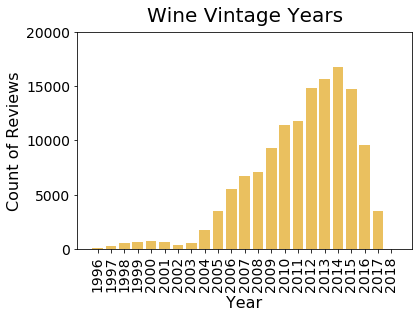

In [455]:
years = list(vintage.index[44:])
fig, ax = plt.subplots()
xvals = [str(val)[:-2] for val in years]
yvals = vintage.values[44:]
plt.xticks(rotation='vertical',fontsize=14)
ax.bar(xvals,yvals, color = colors[1])
ax.tick_params(axis="y", labelsize=14)
ax.set_xticks(xvals)
#x_ticks = np.linspace(1996,2017,6)
y_ticks = np.linspace(0,20000,5)
#ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Count of Reviews",fontsize=16)
ax.set_title("Wine Vintage Years",fontsize=20,pad=10);

## Price vs Score

In [171]:
df_cleaned = df[['price','points']]

In [172]:
df_cleaned = df_cleaned.dropna()

In [173]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131959 entries, 1 to 141616
Data columns (total 2 columns):
price     131959 non-null float64
points    131959 non-null int64
dtypes: float64(1), int64(1)
memory usage: 3.0 MB


In [176]:
df_cleaned = df_cleaned.sort_values(by='points', ascending=True)

In [177]:
df_cleaned.head()

,price,points
48224,10.0,80
41182,19.0,80
39031,19.0,80
48225,12.0,80
118557,14.0,80


In [ ]:
figsize=(10, 6)

In [181]:
df_pricepoints = df_cleaned.groupby('points').median()

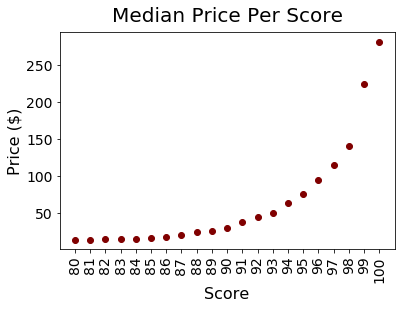

In [458]:
fig, ax = plt.subplots()
xvals = df_pricepoints.index
yvals = df_pricepoints.values
ax.scatter(xvals,yvals,color=colors[2])
ax.tick_params(axis="y", labelsize=14)
plt.xticks(rotation='vertical',fontsize=14)
ax.set_xticks(xvals)
#y_ticks = np.linspace(0,20000,5)
#ax.set_yticks(y_ticks)
ax.set_xlabel("Score",fontsize=16)
ax.set_ylabel("Price ($)",fontsize=16)
ax.set_title("Median Price Per Score",fontsize=20,pad=10);

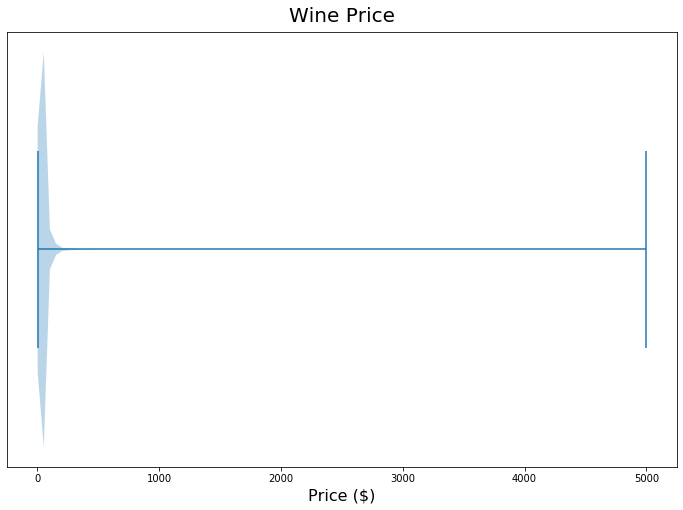

In [195]:
fig, ax = plt.subplots(figsize=(12,8))
ax.violinplot(df_cleaned.price, vert=False)
#ax.set_xlabel("Score",fontsize=16)
ax.set_xlabel("Price ($)",fontsize=16)
plt.tick_params(
    axis='y',         
    left=False,
    labelleft=False)
ax.set_title("Wine Price",fontsize=20,pad=10);

## Price

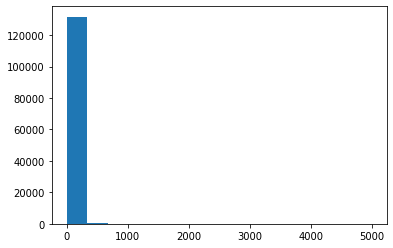

In [8]:
plt.hist(df.price,bins=15);

## Taster

In [15]:
taster = df.groupby('taster_twitter_handle').count()['description']
taster.sort_values(ascending=False)

taster_twitter_handle
@vossroger          28010
@wineschach         16084
@kerinokeefe        12724
@vboone             10844
@paulgwine          10153
@mattkettmann        7625
@wawinereport        5633
@gordone_cellars     5151
@JoeCz               4766
@AnneInVino          4456
@laurbuzz            2004
@worldwineguys       1152
@suskostrzewa        1061
@winewchristina       666
@apatrone23           471
@bkfiona              168
Name: description, dtype: int64

In [16]:
taster = df.groupby('taster_name').count()['description']
taster.sort_values(ascending=False)

taster_name
Roger Voss            28010
Michael Schachner     16084
Kerin O’Keefe         12724
Virginie Boone        10844
Paul Gregutt          10153
Matt Kettmann          7625
Sean P. Sullivan       5633
Jim Gordon             5151
Anna Lee C. Iijima     5075
Joe Czerwinski         4766
Anne Krebiehl MW       4456
Lauren Buzzeo          2004
Susan Kostrzewa        1061
Alexander Peartree      854
Christina Pickard       666
Mike DeSimone           595
Jeff Jenssen            557
Carrie Dykes            274
Fiona Adams             168
Name: description, dtype: int64

In [462]:
len(taster)

19

## Analyzing Description

In [17]:
df_desc = df.description

In [21]:
df_desc.head()

0    Aromas include tropical fruit, broom, brimston...
1    This is ripe and fruity, a wine that is smooth...
2    Tart and snappy, the flavors of lime flesh and...
3    Pineapple rind, lemon pith and orange blossom ...
4    Much like the regular bottling from 2012, this...
Name: description, dtype: object

In [22]:
df_desc = df_desc.str.lower()
df_desc = df_desc.str.replace('[^a-zA-Z0-9 \n\.]', ' ')
df_desc = df_desc.str.replace('\d', ' ')
df_desc = df_desc.str.replace('.', ' ')

In [23]:
df_desc.loc[1]

'this is ripe and fruity  a wine that is smooth while still structured  firm tannins are filled out with juicy red berry fruits and freshened with acidity  it s  already drinkable  although it will certainly be better from      '

In [24]:
df_desc[0]

'aromas include tropical fruit  broom  brimstone and dried herb  the palate isn t overly expressive  offering unripened apple  citrus and dried sage alongside brisk acidity '

## Stemming / Tokenization

In [25]:
desc = df_desc

In [26]:
desc

0         aromas include tropical fruit  broom  brimston...
1         this is ripe and fruity  a wine that is smooth...
2         tart and snappy  the flavors of lime flesh and...
3         pineapple rind  lemon pith and orange blossom ...
4         much like the regular bottling from       this...
5         blackberry and raspberry aromas show a typical...
6         here s a bright  informal red that opens with ...
7         this dry and restrained wine offers spice in p...
8         savory dried thyme notes accent sunnier flavor...
9         this has great depth of flavor with its fresh ...
10        soft  supple plum envelopes an oaky structure ...
11        this is a dry wine  very spicy  with a tight  ...
12        slightly reduced  this wine offers a chalky  t...
13        this is dominated by oak and oak driven aromas...
14        building on     years and six generations of w...
15        zesty orange peels and apple notes abound in t...
16        baked plum  molasses  balsamic

In [27]:
tokenized = [word_tokenize(content.lower()) for content in desc]

KeyboardInterrupt: 

In [ ]:
tokenized

In [ ]:
stop = set(stopwords.words('english'))
docs = [[word for word in words if word not in stop]
        for words in tokenized]

In [39]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [ ]:
docs_porter = [[porter.stem(word) for word in words]
                for words in docs]
docs_snowball = [[snowball.stem(word) for word in words]
                for words in docs]
docs_wordnet = [[wordnet.lemmatize(word) for word in words]
                for words in docs]

In [ ]:
docs_porter

In [ ]:
print("{0}\t{1}\t{2}\t{3}".format("word", "porter", "snowball", "lemmatizer"))
print("-" * 20)
for i in range(min(len(docs_porter[0]), len(docs_snowball[0]), len(docs_wordnet[0]))):
    p, s, w = docs_porter[0][i], docs_snowball[0][i], docs_wordnet[0][i]
    if len(set((p, s, w))) != 1:
        print("{0}\t{1}\t{2}\t{3}".format(docs[0][i], p, s, w))

In [31]:
def tokenize(doc):
    '''
    INPUT: string
    OUTPUT: list of strings

    Tokenize and stem/lemmatize the document.
    '''
    return [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

In [101]:
from sklearn.feature_extraction import stop_words
stop = list(stop_words.ENGLISH_STOP_WORDS)
additional_stop = ['ha', 'le', 'u', 'wa','s','t','s','r','ro','wine','flavor','aromas','finish', 'palate', 'note', 'nose', 'drink', 'ofcut', 'feeeling']
for val in additional_stop:
    stop.append(val)
stop = frozenset(stop)

In [72]:
stop

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'aromas',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',

In [49]:
countvect = CountVectorizer(stop_words=stop, tokenizer=tokenize)
count_vectorized = countvect.fit_transform(desc)

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aroma'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [41]:
words = countvect.get_feature_names()

In [42]:
words

['aa',
 'aacacia',
 'aand',
 'aarde',
 'aaron',
 'ab',
 'abacela',
 'abadal',
 'abadia',
 'abandon',
 'abandoned',
 'abate',
 'abbazia',
 'abbess',
 'abbey',
 'abboccato',
 'abbot',
 'abbott',
 'abbreviated',
 'abc',
 'abeille',
 'abeilles',
 'abeja',
 'abel',
 'abele',
 'abelis',
 'abernathy',
 'aberrant',
 'abetina',
 'abeyance',
 'abide',
 'abiding',
 'abilio',
 'ability',
 'abiouness',
 'able',
 'ably',
 'abnormal',
 'abnormally',
 'aboard',
 'abondante',
 'abord',
 'aboriginal',
 'abound',
 'abounding',
 'abounds',
 'abouriou',
 'abovde',
 'abraham',
 'abrasive',
 'abrasively',
 'abrasiveness',
 'abraxas',
 'abrazo',
 'abreu',
 'abrie',
 'abrigo',
 'abroad',
 'abrupt',
 'abruptly',
 'abruptness',
 'abruzzo',
 'absberg',
 'absence',
 'absense',
 'absent',
 'absinthe',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbing',
 'absorbingly',
 'absorbs',
 'absurd',
 'absurdly',
 'abtsberg',
 'abtsfronhof',
 'abundance',
 'abundant',
 'abundantly',
 'abupt',
 'abused',
 'abuts

In [43]:
lda = LatentDirichletAllocation(n_components=7, max_iter=5, learning_method='online',random_state=0, n_jobs=-1)
lda.fit(count_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=7, n_jobs=-1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [44]:
components = lda.components_

In [45]:
tf_feature_names = np.array(words)

In [46]:
def find_top_words(matrix):
    words = []
    for idx, __ in enumerate(matrix):
        top_words = np.argsort(matrix[idx])[-10:][::-1]
        top_words = tf_feature_names[top_words]
        words.append(top_words)
    return words

In [47]:
top_words_in_topic = find_top_words(components)
top_words_in_topic

[array(['flavor', 'aroma', 'finish', 'fruit', 'palate', 'berry', 'plum',
        'feel', 'herbal', 'note'], dtype='<U20'),
 array(['apple', 'palate', 'flavor', 'acidity', 'wine', 'citrus', 'lemon',
        'white', 'finish', 'fresh'], dtype='<U20'),
 array(['palate', 'aroma', 'black', 'cherry', 'tannin', 'spice', 'red',
        'offer', 'note', 'herb'], dtype='<U20'),
 array(['wine', 'fruit', 'drink', 'tannin', 'acidity', 'ripe', 'rich',
        'flavor', 'black', 'year'], dtype='<U20'),
 array(['flavor', 'cherry', 'wine', 'bodied', 'make', 'oak', 'sweet',
        'finish', 'raspberry', 'blackberry'], dtype='<U20'),
 array(['vineyard', 'bottling', 'new', 'oak', 'grape', 'vine', 'old',
        'estate', 'french', 'valley'], dtype='<U20'),
 array(['taste', 'cranberry', 'wine', 'big', 'blend', 'syrah', 'best',
        'fruit', 'chocolate', 'end'], dtype='<U20')]

In [ ]:
theta = lda.transform(count_vectorized)

In [ ]:
def find_similar_wines(wine_title):
    awine_idx = df[df['title'] == wine_title].index[0]
    dists = cosine_distances(theta, theta)
    top_wines = np.argsort(dists[wine_idx,:])[-10:][::1]
    top_wines = df.title[top_wines]
    return top_wines[1:]

In [ ]:
wine_title = 'Quinta dos Avidagos 2011 Avidagos Red (Douro)'

In [30]:
#find_similar_wines(wine_title)

## Testing NMF

In [74]:
tf_vect = TfidfVectorizer(stop_words=stop,tokenizer=tokenize)
tf = tf_vect.fit_transform(desc)

//anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aroma'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [84]:
nmf = NMF(n_components = 10)
nmf.fit(tf)
W = nmf.transform(tf)
H = nmf.components_
topic_words = find_top_words(H)

In [81]:
topic_words #4

[array(['black', 'cherry', 'tanins', 'aroma', 'alongside', 'berry',
        'oeuvre', 'recreates', 'spends', 'pepella'], dtype='<U20'),
 array(['apple', 'whispering', 'citrus', 'freres', 'lemelson', 'crisp',
        'acidity', 'pazzo', 'peachy', 'lifting'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'acidity', 'ric', 'tanins', 'wonderful',
        'character', 'texbook', 'reactive', 'aging'], dtype='<U20'),
 array(['cabernet', 'nymph', 'blend', 'blackberry', 'sauteed', 'merited',
        'cherry', 'chocolate', 'plowbuster', 'sweaty'], dtype='<U20')]

In [79]:
topic_words #5

[array(['cherry', 'black', 'aroma', 'tanins', 'berry', 'alongside',
        'oeuvre', 'spends', 'plowbuster', 'pepella'], dtype='<U20'),
 array(['apple', 'whispering', 'lemelson', 'citrus', 'pazzo', 'peachy',
        'aroma', 'greco', 'lima', 'freres'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'ric', 'tanins', 'wonderful', 'aging',
        'strove', 'black', 'yarrabank', 'age'], dtype='<U20'),
 array(['cabernet', 'blend', 'sauteed', 'merited', 'nymph', 'blackberry',
        'framework', 'synchronize', 'chocolate', 'cherry'], dtype='<U20'),
 array(['fruitiness', 'acidity', 'recreates', 'lifting', 'crisp',
        'socking', 'reactive', 'freres', 'bright', 'attractive'],
       dtype='<U20')]

In [77]:
topic_words #6

[array(['black', 'cherry', 'tanins', 'aroma', 'alongside', 'oeuvre',
        'pepella', 'berry', 'spends', 'recreates'], dtype='<U20'),
 array(['apple', 'whispering', 'lemelson', 'citrus', 'pazzo', 'peachy',
        'greco', 'lima', 'freres', 'aroma'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'ric', 'tanins', 'wonderful', 'aging',
        'strove', 'black', 'age', 'firewood'], dtype='<U20'),
 array(['nymph', 'aroma', 'sweaty', 'plowbuster', 'cherry', 'feeding',
        'valued', 'blackberry', 'berry', 'herbacesously'], dtype='<U20'),
 array(['fruitiness', 'acidity', 'recreates', 'crisp', 'lifting',
        'socking', 'reactive', 'freres', 'attractive', 'bright'],
       dtype='<U20'),
 array(['cabernet', 'sauteed', 'blend', 'merited', 'framework', 'verdesca',
        'petal', 'synchronize', 'malagousia', 'currant'], dtype='<U20')]

In [83]:
topic_words #7

[array(['black', 'cherry', 'tanins', 'alongside', 'aroma', 'oeuvre',
        'pepella', 'spends', 'dried', 'lick'], dtype='<U20'),
 array(['apple', 'whispering', 'lemelson', 'citrus', 'pazzo', 'peachy',
        'aroma', 'lima', 'greco', 'yearold'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'ric', 'tanins', 'wonderful', 'aging',
        'strove', 'black', 'firewood', 'age'], dtype='<U20'),
 array(['nymph', 'sweaty', 'cherry', 'valued', 'bodied', 'pinkish',
        'liguria', 'rasina', 'blackberry', 'drupeggio'], dtype='<U20'),
 array(['fruitiness', 'acidity', 'crisp', 'recreates', 'lifting',
        'socking', 'reactive', 'attractive', 'bright', 'freres'],
       dtype='<U20'),
 array(['cabernet', 'sauteed', 'blend', 'merited', 'framework', 'verdesca',
        'petal', 'synchronize', 'malagousia', 'currant'], dtype='<U20'),
 array(['berry', 'plowbuster', 'aroma', 'herbacesously', 'feeding',
        'fruchtig', 'recreates', 'earthshaking', 'greco', 'spicebox'],
       dtype='<U20')]

In [85]:
topic_words #10

[array(['alongside', 'tanins', 'oeuvre', 'aroma', 'cherry', 'spends',
        'berry', 'dried', 'recreates', 'clove'], dtype='<U20'),
 array(['apple', 'whispering', 'lemelson', 'citrus', 'pazzo', 'peachy',
        'lima', 'greco', 'freres', 'yearold'], dtype='<U20'),
 array(['fruchtig', 'ripan', 'ric', 'wonderful', 'tanins', 'aging',
        'strove', 'age', 'firewood', 'yarrabank'], dtype='<U20'),
 array(['nymph', 'sweaty', 'valued', 'tl', 'blackberry', 'neve', 'socking',
        'freindly', 'chardonnay', 'pinard'], dtype='<U20'),
 array(['fruitiness', 'acidity', 'crisp', 'socking', 'reactive', 'lifting',
        'recreates', 'attractive', 'bright', 'freres'], dtype='<U20'),
 array(['cabernet', 'sauteed', 'blend', 'merited', 'framework', 'verdesca',
        'petal', 'synchronize', 'malagousia', 'hepped'], dtype='<U20'),
 array(['berry', 'plowbuster', 'aroma', 'herbacesously', 'feeding',
        'fruchtig', 'earthshaking', 'greco', 'recreates', 'spicebox'],
       dtype='<U20'),
 array

## Using Gensim Pipeline

In [202]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        stem = lemmatize_stemming(token)
        if stem not in stop_words and len(stem) > 3:
            result.append(stem)
    return result

In [203]:
raw_data = '../data/winemag-data-190314.csv'
df = pd.read_csv(raw_data)
df.drop(labels='Unnamed: 0',axis=1,inplace=True)
desc = df.description
desc = desc.str.lower()
desc = desc.str.replace('[^a-zA-Z0-9 \n\.]', ' ')
desc = desc.str.replace('\d', ' ')
desc = desc.str.replace('.', ' ')

additional_stop = ['wine','flavor','aromas','finish', 'palate', 'note', 'nose', 'drink', 'fruit', 'like']
stop_words = list(STOPWORDS)
for val in additional_stop:
    stop_words.append(val)
stop_words = frozenset(stop_words)

processed_docs = desc.map(preprocess)

In [204]:
type(processed_docs)

pandas.core.series.Series

In [206]:
doc_lens = [len(doc) for doc in processed_docs]

In [216]:
len(processed_docs[0])

15

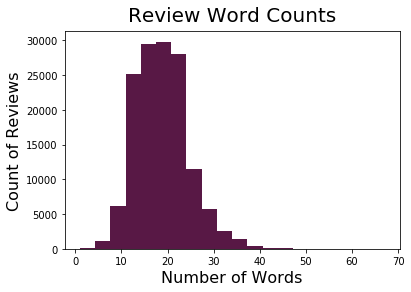

In [459]:
fig, ax = plt.subplots()
ax.hist(doc_lens, bins = 20,color=colors[0])
ax.set_xlabel("Number of Words",fontsize=16)
ax.set_ylabel("Count of Reviews",fontsize=16)
ax.set_title("Review Word Counts",fontsize=20,pad=10);

In [256]:
wine_desc = pd.DataFrame(doc_lens,df.points,columns=['word_cnt'])

In [257]:
wine_desc.index

Int64Index([87, 87, 87, 87, 87, 87, 87, 87, 87, 87,
            ...
            92, 92, 92, 92, 92, 92, 92, 92, 92, 92],
           dtype='int64', name='points', length=141617)

In [258]:
wine_desc.reset_index(inplace=True)

In [259]:
wine_desc.head()

,points,word_cnt
0,87,15
1,87,13
2,87,15
3,87,16
4,87,19


In [260]:
wine_points_desc = wine_desc.groupby('points').median()

In [261]:
wine_points_desc

,word_cnt
points,
80,11
81,12
82,12
83,14
84,14
85,15
86,16
87,17
88,18


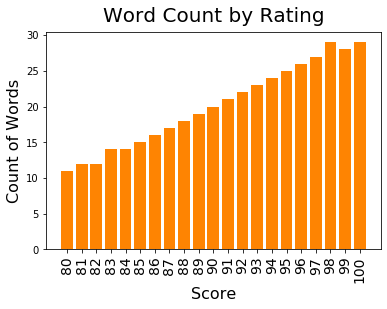

In [461]:
fig, ax = plt.subplots()
xvals = wine_points_desc.index
yvals = wine_points_desc.word_cnt
plt.xticks(rotation='vertical',fontsize=14)
ax.bar(xvals,yvals,color=colors[4])
#ax.tick_params(axis="y", labelsize=14)
ax.set_xticks(xvals)
#y_ticks = np.linspace(0,20000,5)
#ax.set_yticks(y_ticks)
ax.set_xlabel("Score",fontsize=16)
ax.set_ylabel("Count of Words",fontsize=16)
ax.set_title("Word Count by Rating",fontsize=20,pad=10);

## Wordcloud

In [85]:
topic = 0

In [76]:
cloud_df = pd.read_csv('../data/ignore/cloud_df')

In [81]:
cloud_df

,acidity,alongside,apple,brimstone,brisk,broom,citrus,expressive,herb,include,...,stealthily,oppressively,attunga,souffle,baton,batuta,conductor,instrument,soufre,verse
0,0.026248,0.000986,0.014623,0.000004,0.000869,0.000055,0.009277,0.000180,0.003367,0.000678,...,5.011530e-07,5.011527e-07,5.011536e-07,5.011530e-07,5.011534e-07,5.011534e-07,5.011534e-07,5.011534e-07,5.011531e-07,5.025056e-07
1,0.008361,0.001274,0.003689,0.000014,0.000911,0.000056,0.003183,0.000227,0.002539,0.001026,...,4.048863e-07,4.112625e-07,4.262126e-07,4.048862e-07,4.048865e-07,4.048865e-07,4.048865e-07,4.048865e-07,4.115850e-07,4.048863e-07
2,0.013748,0.001784,0.011367,0.000035,0.001604,0.000286,0.010586,0.000456,0.001306,0.000517,...,3.964672e-07,3.696841e-07,3.696849e-07,4.148357e-07,3.696847e-07,3.696847e-07,3.696847e-07,3.696847e-07,3.990027e-07,4.160128e-07
3,0.009782,0.001952,0.002423,0.000009,0.001123,0.000078,0.002963,0.000227,0.001633,0.000859,...,3.427302e-07,3.520674e-07,3.425639e-07,3.425636e-07,3.437681e-07,3.437681e-07,3.437681e-07,3.437681e-07,3.425637e-07,3.425637e-07
4,0.014075,0.006501,0.002945,0.000056,0.000558,0.000030,0.002295,0.000284,0.005795,0.000468,...,2.939270e-07,2.946715e-07,2.925496e-07,2.925494e-07,2.925496e-07,2.925496e-07,2.925496e-07,2.925496e-07,2.940792e-07,2.925495e-07
5,0.017506,0.000892,0.004202,0.000025,0.000244,0.000116,0.003721,0.000120,0.001190,0.000489,...,4.159024e-07,4.216550e-07,4.270932e-07,4.159023e-07,4.552545e-07,4.552545e-07,4.552545e-07,4.552545e-07,4.159024e-07,4.159025e-07
6,0.014733,0.001609,0.002986,0.000015,0.000397,0.000013,0.003290,0.000305,0.002732,0.001057,...,3.566625e-07,3.509320e-07,3.509325e-07,3.520116e-07,3.509324e-07,3.509324e-07,3.509324e-07,3.509324e-07,3.509322e-07,3.509323e-07


In [78]:
cloud_df.drop(labels='Unnamed: 0',axis=1,inplace=True)

In [86]:
cloud_df.loc[topic]

acidity           2.624799e-02
alongside         9.858649e-04
apple             1.462254e-02
brimstone         3.852906e-06
brisk             8.693566e-04
broom             5.470589e-05
citrus            9.277270e-03
expressive        1.801871e-04
herb              3.366599e-03
include           6.779254e-04
offer             6.051411e-03
overly            1.149815e-04
sage              2.090872e-04
tropical          1.780821e-03
unripened         5.014230e-07
berry             3.465362e-03
better            1.293259e-03
certainly         5.589870e-04
drinkable         6.912665e-04
firm              3.730275e-03
freshen           1.156332e-04
fruity            8.833597e-03
juicy             5.007255e-03
ripe              1.265210e-02
smooth            1.230092e-03
structure         5.264563e-03
tannins           9.336276e-03
crisp             1.358095e-02
dominate          1.527418e-03
ferment           5.346302e-04
                      ...     
elberberry        5.011537e-07
circumna

In [87]:
top_words = np.argsort(cloud_df.loc[topic])[-30:][::-1]

In [88]:
cloud_df.loc[topic][top_words]

acidity       0.026248
fresh         0.015514
apple         0.014623
crisp         0.013581
ripe          0.012652
blend         0.010075
tannins       0.009336
citrus        0.009277
spice         0.008879
fruity        0.008834
light         0.008555
green         0.008361
lemon         0.008273
texture       0.007942
balance       0.007532
cherry        0.007487
character     0.007248
bright        0.006501
touch         0.006395
offer         0.006051
attractive    0.005898
good          0.005727
sauvignon     0.005695
black         0.005445
structure     0.005265
wood          0.005214
aftertaste    0.005159
juicy         0.005007
feel          0.004827
rich          0.004795
Name: 0, dtype: float64

In [89]:
top_words_0 = cloud_df.loc[topic][top_words]

In [90]:
top_words_0 = top_words_0*1000

In [91]:
top_words_0

acidity       26.247990
fresh         15.514008
apple         14.622535
crisp         13.580952
ripe          12.652103
blend         10.074791
tannins        9.336276
citrus         9.277270
spice          8.879065
fruity         8.833597
light          8.554657
green          8.361070
lemon          8.272733
texture        7.942118
balance        7.531991
cherry         7.487003
character      7.248079
bright         6.501000
touch          6.394654
offer          6.051411
attractive     5.898310
good           5.727387
sauvignon      5.695415
black          5.445364
structure      5.264563
wood           5.213518
aftertaste     5.158704
juicy          5.007255
feel           4.827019
rich           4.795402
Name: 0, dtype: float64

In [92]:
type(top_words_0)

pandas.core.series.Series

In [93]:
top_words_0.index

Index(['acidity', 'fresh', 'apple', 'crisp', 'ripe', 'blend', 'tannins',
       'citrus', 'spice', 'fruity', 'light', 'green', 'lemon', 'texture',
       'balance', 'cherry', 'character', 'bright', 'touch', 'offer',
       'attractive', 'good', 'sauvignon', 'black', 'structure', 'wood',
       'aftertaste', 'juicy', 'feel', 'rich'],
      dtype='object')

In [94]:
freq = []
for idx, val in zip(top_words_0.index,top_words_0):
    for _ in range(round(val)):
        freq.append(idx)

In [95]:
freq

['acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'fresh',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'apple',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'crisp',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'ripe',
 'blend',
 'blend',
 'blend',
 'blend',
 'blend',
 'blend',
 'blend',
 'blend',
 'blend',
 'blend',
 'tannins',
 'tannins

In [96]:
import random
from PIL import Image

In [97]:
random.shuffle(freq)

In [98]:
freq_str = ' '.join(freq)

In [99]:
freq_str

'texture fresh tannins acidity crisp tannins blend light fresh ripe balance cherry crisp offer structure character attractive fresh ripe apple structure feel attractive citrus ripe acidity wood spice ripe sauvignon ripe sauvignon crisp apple wood juicy blend light crisp balance fruity aftertaste citrus crisp apple green cherry bright bright acidity offer texture aftertaste apple bright touch ripe sauvignon fresh texture acidity black touch apple light offer citrus black ripe tannins structure green acidity fruity rich fruity sauvignon citrus light lemon cherry crisp aftertaste spice spice green lemon acidity acidity acidity wood feel fresh blend green fruity acidity acidity light black blend attractive acidity ripe citrus lemon fresh acidity juicy character ripe spice balance fresh blend balance offer light apple texture acidity bright texture fresh apple aftertaste sauvignon cherry wood ripe fruity crisp feel acidity apple light blend juicy citrus texture feel character wood tannins o

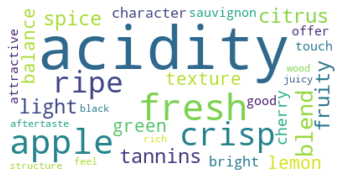

In [103]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop, background_color="white",relative_scaling=1).generate(freq_str)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [165]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return num

In [178]:
wine_mask = np.array(Image.open("../images/bottles2.png"))

In [167]:
transformed_wine_mask = np.ndarray((wine_mask.shape[0],wine_mask.shape[1]), np.int32)

for i in range(len(wine_mask)):
    transformed_wine_mask[i] = list(map(transform_format, wine_mask[i]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [168]:
wine_mask[0]

array([[255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 255, 255, 255],
       [255, 2

In [163]:
transformed_wine_mask[0]

array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 250, 143,   9,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,   9, 143, 250, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 25

In [149]:
wine_mask

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [186]:
wc = WordCloud(background_color="white", max_words=20, mask=wine_mask,
               stopwords=stop, contour_width=1, contour_color='black')

# Generate a wordcloud
wc.generate(freq_str)

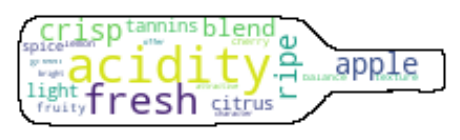

In [188]:
plt.figure(figsize=[8,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## another category

In [419]:
top_words_6 = np.argsort(cloud_df.loc[6])[-30:][::-1]

In [420]:
cloud_df.loc[6][top_words_6]

berry         0.016454
tannins       0.015111
acidity       0.014733
plum          0.014393
spice         0.013242
cherry        0.013188
vanilla       0.008257
feel          0.008167
herbal        0.008146
good          0.008077
black         0.007959
offer         0.007515
blackberry    0.007414
soft          0.006988
balance       0.006903
sweet         0.006713
ripe          0.006600
touch         0.006166
bite          0.005726
green         0.005725
body          0.005624
dark          0.005619
bake          0.005297
rich          0.005145
come          0.004811
cabernet      0.004643
raspberry     0.004630
blend         0.004417
taste         0.004337
chocolate     0.004332
Name: 6, dtype: float64

In [421]:
top_words_6 = cloud_df.loc[6][top_words_6]

In [422]:
top_words_6

berry         0.016454
tannins       0.015111
acidity       0.014733
plum          0.014393
spice         0.013242
cherry        0.013188
vanilla       0.008257
feel          0.008167
herbal        0.008146
good          0.008077
black         0.007959
offer         0.007515
blackberry    0.007414
soft          0.006988
balance       0.006903
sweet         0.006713
ripe          0.006600
touch         0.006166
bite          0.005726
green         0.005725
body          0.005624
dark          0.005619
bake          0.005297
rich          0.005145
come          0.004811
cabernet      0.004643
raspberry     0.004630
blend         0.004417
taste         0.004337
chocolate     0.004332
Name: 6, dtype: float64

In [423]:
top_words_6 = top_words_6*1000

In [424]:
top_words_6

berry         16.454035
tannins       15.111097
acidity       14.732542
plum          14.393437
spice         13.241898
cherry        13.187651
vanilla        8.256587
feel           8.166921
herbal         8.145678
good           8.077499
black          7.958536
offer          7.515294
blackberry     7.413967
soft           6.987951
balance        6.903239
sweet          6.713006
ripe           6.599906
touch          6.166461
bite           5.726080
green          5.724863
body           5.623947
dark           5.619235
bake           5.297490
rich           5.145279
come           4.810992
cabernet       4.643203
raspberry      4.629764
blend          4.417370
taste          4.336936
chocolate      4.331783
Name: 6, dtype: float64

In [425]:
top_words_6.index

Index(['berry', 'tannins', 'acidity', 'plum', 'spice', 'cherry', 'vanilla',
       'feel', 'herbal', 'good', 'black', 'offer', 'blackberry', 'soft',
       'balance', 'sweet', 'ripe', 'touch', 'bite', 'green', 'body', 'dark',
       'bake', 'rich', 'come', 'cabernet', 'raspberry', 'blend', 'taste',
       'chocolate'],
      dtype='object')

In [426]:
freq = []
for idx, val in zip(top_words_6.index,top_words_6):
    for _ in range(round(val)):
        freq.append(idx)

In [427]:
freq

['berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'berry',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'tannins',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'acidity',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'plum',
 'spice',
 'spice',
 'spice',
 'spice',
 'spice',
 'spice',
 'spice',
 'spice',
 'spice',
 'spice',
 'spice',
 'spice',
 'spice',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'cherry',
 'vanilla',
 'vanilla',
 'vanilla',
 'vanilla',
 'vanilla',
 'vanilla',
 'vanilla

In [428]:
random.shuffle(freq)

In [429]:
freq_str2 = ' '.join(freq)

In [430]:
freq_str2

'tannins chocolate vanilla berry cherry acidity spice acidity offer tannins bake acidity feel come good soft feel bite cherry plum chocolate green herbal blackberry ripe sweet body black good sweet raspberry dark blend feel cherry vanilla sweet bite balance balance berry body soft acidity berry rich berry spice balance tannins vanilla touch plum taste herbal ripe green blackberry blend touch bite plum spice acidity plum plum dark plum body cabernet plum taste balance ripe rich dark cherry raspberry body blackberry spice bite chocolate black berry come tannins acidity plum feel tannins acidity body offer green vanilla tannins rich blackberry cherry plum touch berry ripe tannins cherry herbal balance berry plum herbal tannins soft tannins ripe balance ripe dark berry cherry spice berry blend dark berry blackberry tannins acidity tannins black plum vanilla green acidity cherry sweet cabernet spice bite spice offer cherry berry sweet herbal feel sweet taste plum spice good raspberry bite h

In [470]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 9 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)


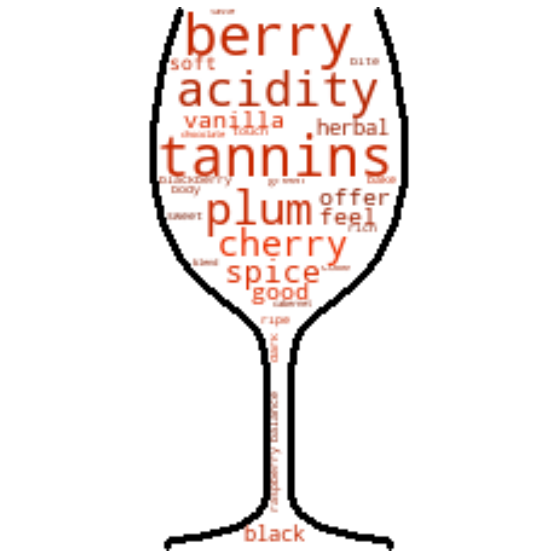

In [471]:
wc = WordCloud(background_color="white", max_words=50, mask=transformed_wine_mask,
               stopwords=stop_words, contour_width=3, contour_color='black',color_func=random_color_func)

# Generate a wordcloud
wc.generate(freq_str2)

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()